# Model Training and Evaluation

In [72]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import pickle
import os


## Base Model

In [73]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed_1/train_preprocessed_1_dummies.pkl')

In [74]:
train.head()

,id,Age,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenient,Ease of Online Booking,Gate Location,Food and Drink,Online Boarding,...,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction,Dummy_Female,Dummy_Male,Dummy_Disloyal customer,Dummy_Loyal customer,Dummy_Business travel,Dummy_Personal travel
0,70172,13,2,460,3,4,3,1,5,3,...,5,25,18.0,neutral or dissatisfied,0,1,0,1,0,1
1,5047,25,3,235,3,2,3,3,1,3,...,1,1,6.0,neutral or dissatisfied,0,1,1,0,1,0
2,110028,26,3,1142,2,2,2,2,5,5,...,5,0,0.0,satisfied,1,0,0,1,1,0
3,24026,25,3,562,2,5,5,5,2,2,...,2,11,9.0,neutral or dissatisfied,1,0,0,1,1,0
4,119299,61,3,214,3,3,3,3,4,5,...,3,0,0.0,satisfied,0,1,0,1,1,0


In [75]:
# Splitting the data into train and test sets:
X = train.drop(columns = 'Satisfaction', axis = 1)
y = train['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
# Defining and implementing the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Kfold cross-validation is used to ensure reproducibility of results:
# results = []

# for name, model in models.items():
    # kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    # for result in cv_results:
       # results.append([name, result])

# Convert results into a DataFrame:
# bm_data = pd.DataFrame(results, columns=['Model', 'Metric'])

# Saving results:
# bm_data.to_pickle('../Models/Model_1/bm_data.pkl')

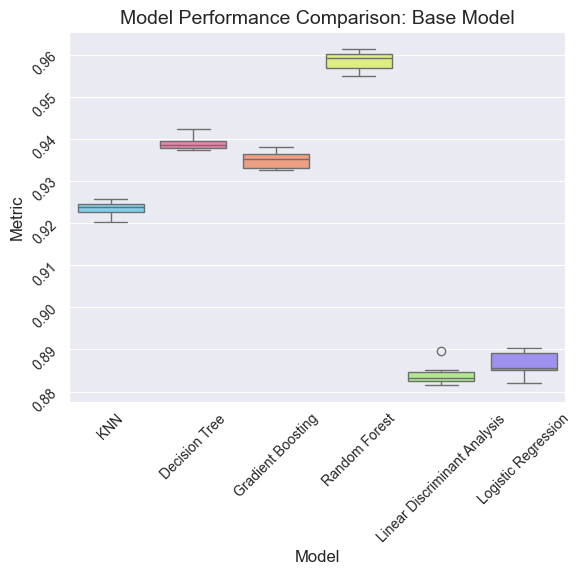

In [88]:
# Loading the results:
bm_data = pd.read_pickle('../Models/Model_1/bm_data.pkl')

# Plotting the boxplots:
sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bm_data, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Metric', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

In [79]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier(),
          'linear_discriminant_analysis': LinearDiscriminantAnalysis(),
          'logistic_regression': LogisticRegression()}

# for name, model in models.items():
     # model.fit(X_train_scaled, y_train)
     # test_score = model.score(X_test_scaled, y_test)
     # print('{} test set accuracy: {}'.format(name, test_score))
     # save each model as a pickle file
     # model_pkl_file = '../Models/Model_1/{}.pkl'.format(name)  
     # with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model, file)

knn test set accuracy: 0.9236494289747209
decision_tree test set accuracy: 0.9392724239702297
gradient_boosting test set accuracy: 0.9354228153471064
random_forest test set accuracy: 0.9585525471577057
linear_discriminant_analysis test set accuracy: 0.8840626203002695
logistic_regression test set accuracy: 0.8871423071987681


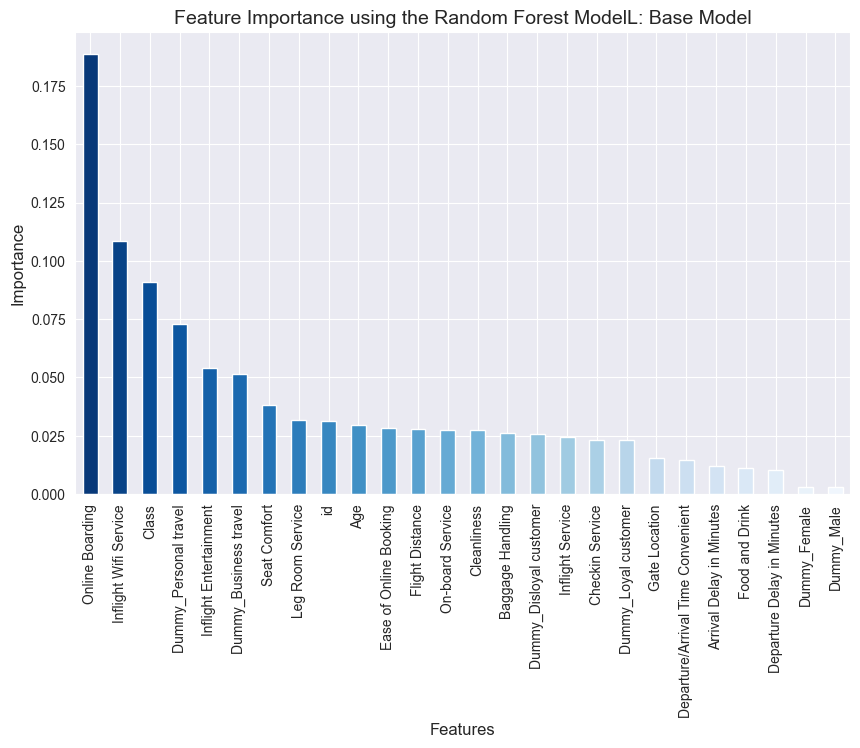

In [80]:
# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Model_1/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest ModelL: Base Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

## Feature Selection Model

In [84]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [85]:
# Splitting the data into train and test sets:
X = train_fs.drop(columns = 'Satisfaction', axis = 1)
y = train_fs['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
# Defining and implementing the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Kfold cross-validation is used to ensure reproducibility of results:
# results = []

# for name, model in models.items():
    # kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    # for result in cv_results:
       # results.append([name, result])

# Convert results into a DataFrame:
# kf_cv_data = pd.DataFrame(results, columns=['Model', 'Metric'])

# Saving results:
# kf_cv_data.to_pickle('../Models/Model_2/kf_cv_data.pkl')

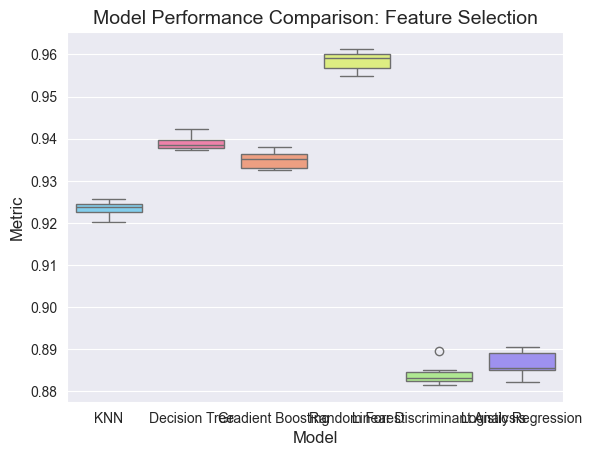

In [89]:
# Loading the results:
kf_cv_data = pd.read_pickle('../Models/Model_2/kf_cv_data.pkl')

# Plotting the boxplots:
sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bm_data, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Selection', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Metric', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10)

plt.show()

In [32]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier()}

# for name, model in models.items():
     # model.fit(X_train_scaled, y_train)
     # test_score = model.score(X_test_scaled, y_test)
     # print('{} test set accuracy: {}'.format(name, test_score))
     # save each model as a pickle file
     # model_pkl_file = '../Models/Model_2/{}.pkl'.format(name)  
     # with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model, file)

knn test set accuracy: 0.9381279924472318
decision_tree test set accuracy: 0.9420055297053072
gradient_boosting test set accuracy: 0.9457481961022322
random_forest test set accuracy: 0.9640906332186931


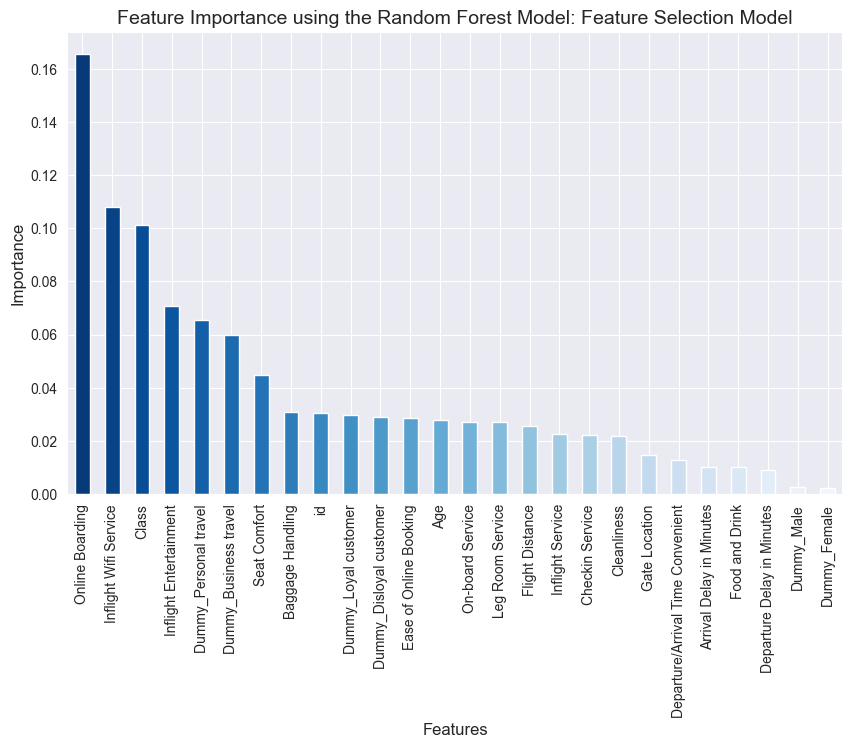

In [33]:
# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Model_2/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest Model: Feature Selection Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

# Feature Extraction Model

In [48]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [49]:
# Splitting the data into train and test sets:
X = train_oss.drop(columns = 'Satisfaction', axis = 1)
y = train_oss['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Defining and implementing the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier()}

# Kfold cross-validation is used to ensure reproducibility of results:
# results = []

# for name, model in models.items():
    # kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    # for result in cv_results:
       # results.append([name, result])

# Convert results into a DataFrame:
# kf_cv_data = pd.DataFrame(results, columns=['Model', 'Metric'])

# Saving results:
# kf_cv_data.to_pickle('../Models/Model_3/kf_cv_data.pkl')

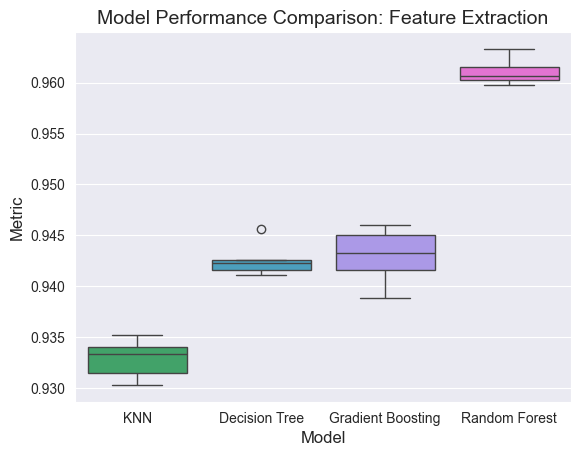

In [51]:
# Loading the results:
kf_cv_data = pd.read_pickle('../Models/Model_3/kf_cv_data.pkl')

# Plotting the boxplots:
sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=kf_cv_data, 
            palette=[husl_palette[3], husl_palette[5], husl_palette[6], husl_palette[7]])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Extraction', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Metric', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10)

plt.show()

In [52]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier()}

# for name, model in models.items():
     # model.fit(X_train_scaled, y_train)
     # test_score = model.score(X_test_scaled, y_test)
     # print('{} test set accuracy: {}'.format(name, test_score))
     # save each model as a pickle file
     # model_pkl_file = '../Models/Model_3/{}.pkl'.format(name)  
     # with open(model_pkl_file, 'wb') as file:  
         # pickle.dump(model, file)

knn test set accuracy: 0.9370827432733158
decision_tree test set accuracy: 0.9422078359970328
gradient_boosting test set accuracy: 0.9459167846786701
random_forest test set accuracy: 0.9632139726212152
